In [186]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline

In [187]:
video_count = pd.read_csv('video_count.csv', parse_dates=['date'])
video_features = pd.read_csv('video_features.csv', parse_dates=['video_upload_date'])

In [188]:
video_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   video_id  41775 non-null  int64         
 1   count     41775 non-null  int64         
 2   date      41775 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 979.2 KB


In [189]:
video_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           2785 non-null   int64         
 1   video_length       2785 non-null   int64         
 2   video_language     2785 non-null   object        
 3   video_upload_date  2785 non-null   datetime64[ns]
 4   video_quality      2785 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 108.9+ KB


In [190]:
len(video_count['video_id'].unique())

2785

In [191]:
data = pd.merge(left = video_count, right = video_features, how = 'left', on = 'video_id')
data = data.rename(columns={'video_length': 'length', 
                            'video_language': 'language', 
                            'video_upload_date': 'upload_date', 
                            'video_quality': 'quality'})
data.head()

,video_id,count,date,length,language,upload_date,quality
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p
3,1472,234,2015-01-04,157,Other,2014-12-10,240p
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p


In [192]:
data['interval'] = (data['date'] - data['upload_date']).apply(lambda x: x.days)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

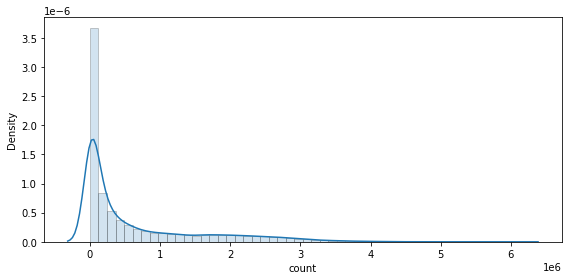

In [193]:
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data['count'], ax=ax, hist_kws=hist_kws)

plt.tight_layout()
plt.show()

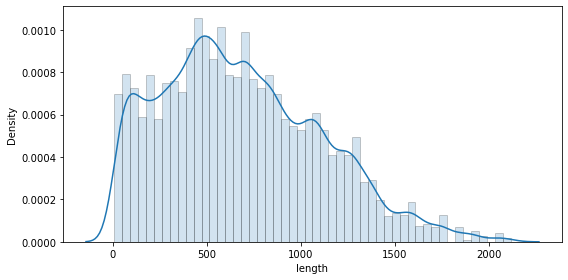

In [194]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data['length'], ax=ax, hist_kws=hist_kws)

plt.tight_layout()
plt.show()

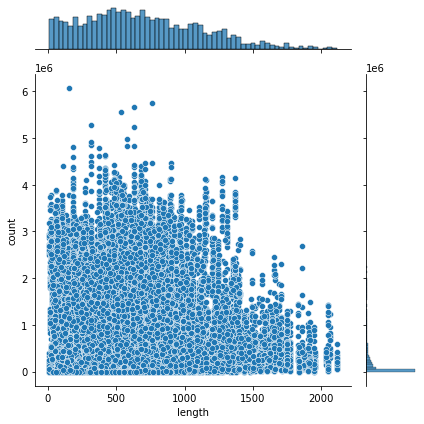

In [195]:
sns.jointplot(x='length', y='count', data=data, kind='scatter', size=6)
plt.tight_layout()
plt.show()

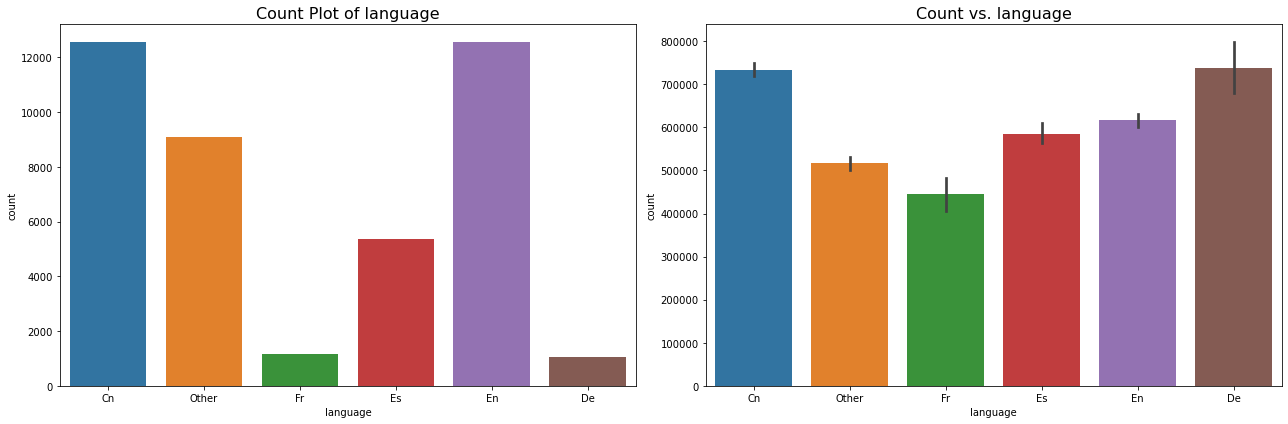

In [196]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='language', data=data, ax=ax[0])
ax[0].set_title('Count Plot of language', fontsize=16)

sns.barplot(x='language', y='count', data=data, ax=ax[1])
ax[1].set_title('Count vs. language', fontsize=16)
plt.tight_layout()
plt.show()

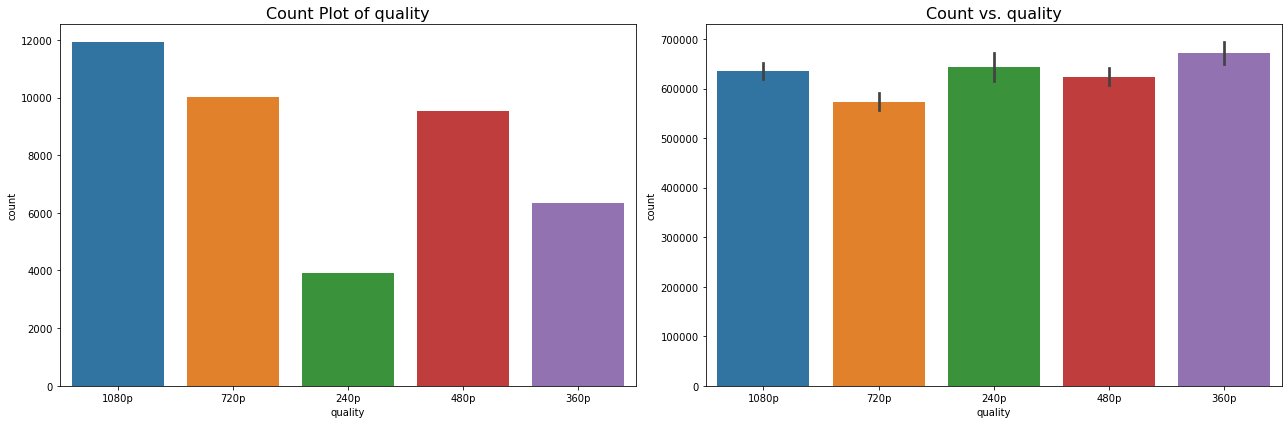

In [197]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='quality', data=data, ax=ax[0])
ax[0].set_title('Count Plot of quality', fontsize=16)

sns.barplot(x='quality', y='count', data=data, ax=ax[1])
ax[1].set_title('Count vs. quality', fontsize=16)
plt.tight_layout()
plt.show()

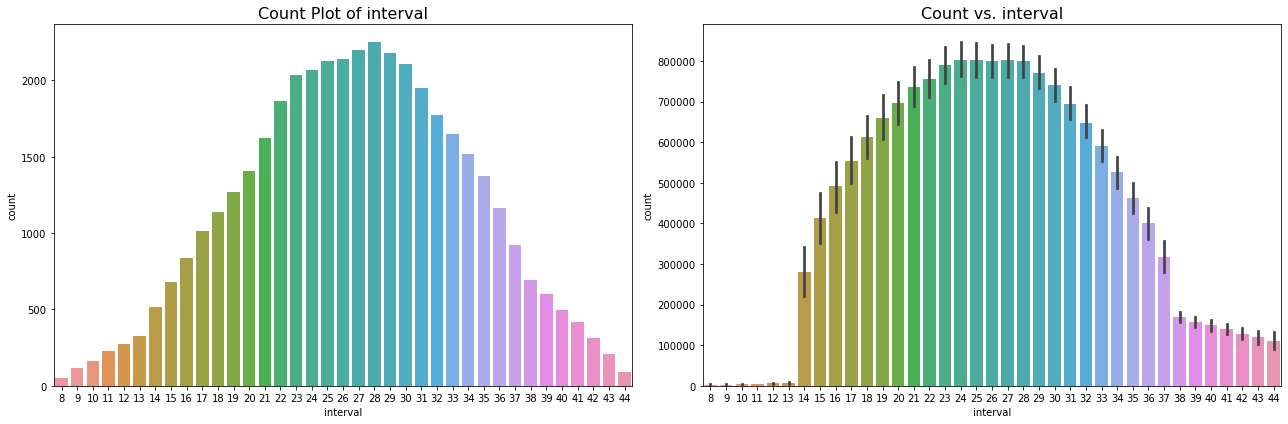

In [198]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='interval', data=data, ax=ax[0])
ax[0].set_title('Count Plot of interval', fontsize=16)

sns.barplot(x='interval', y='count', data=data, ax=ax[1])
ax[1].set_title('Count vs. interval', fontsize=16)
plt.tight_layout()
plt.show()

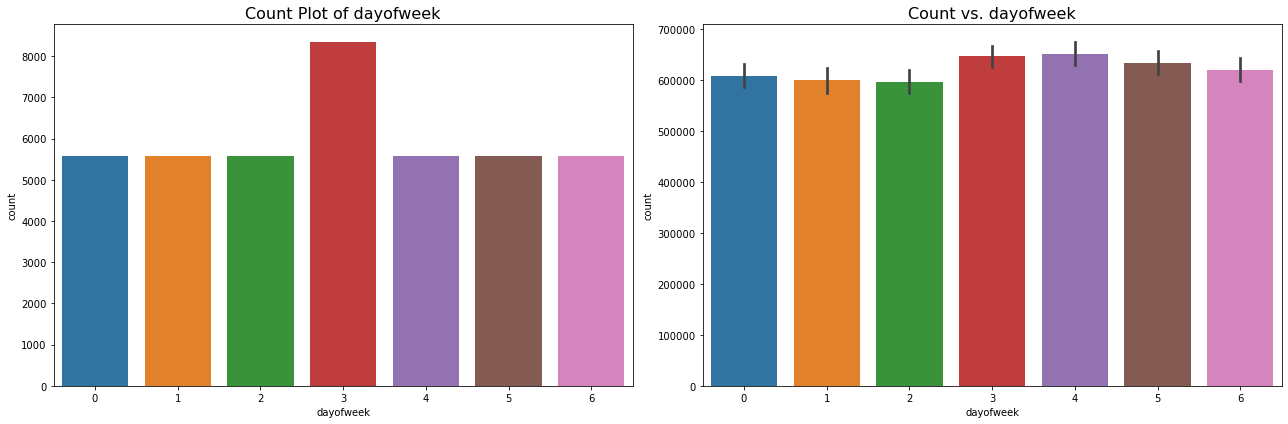

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='dayofweek', data=data, ax=ax[0])
ax[0].set_title('Count Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='count', data=data, ax=ax[1])
ax[1].set_title('Count vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

# Classify each video into one the 3 categories below and explain your approach
"Hot" - means trending up. These videos are candidate to be shown.

"Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too.

"Everything else" - these videos won't be shown.

In [200]:
def parse_data(df):
    """ function to calculate the statistics for """
    counts = df.sort_values(by='date')['count'].values
    change = (counts[1:] - counts[:-1]) / counts[:-1]
    
    index = ['ct_mean', 'ct_std', 'ct_min', 'ct_25%', 'ct_50%', 'ct_75%', 'ct_max', 
             'cg_mean', 'cg_std', 'cg_min', 'cg_25%', 'cg_50%', 'cg_75%', 'cg_max']
    
    ct_vals = pd.Series(counts).describe()
    cg_vals = pd.Series(change).describe()
    
    ct_values = [ct_vals['mean'], ct_vals['std'], ct_vals['min'], ct_vals['25%'], 
                 ct_vals['50%'], ct_vals['75%'], ct_vals['max']]
    cg_values = [cg_vals['mean'], cg_vals['std'], cg_vals['min'], cg_vals['25%'], 
                 cg_vals['50%'], cg_vals['75%'], cg_vals['max']]
    
    return pd.Series(ct_values + cg_values, index=index)

data_stats = data.groupby('video_id').apply(parse_data)
data_stats.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
1,7.063560e+04,39200.460092,19382.0,41099.0,65907.0,96335.0,140460.0,-0.127437,0.092392,-0.271522,-0.186381,-0.151384,-0.067977,0.030277
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
5,4.479973e+05,237137.305768,169730.0,255574.5,388594.0,609508.0,983058.0,-0.111811,0.107193,-0.269337,-0.177432,-0.133447,-0.012729,0.031766


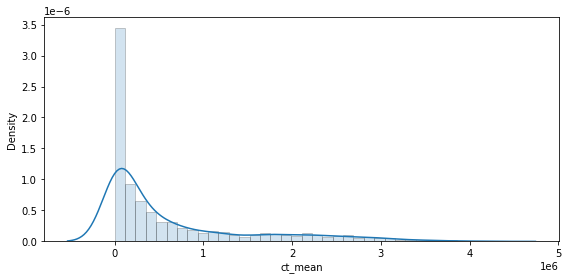

In [201]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data_stats['ct_mean'], ax=ax, hist_kws=hist_kws)
plt.tight_layout()
plt.show()

Above figure it the density across videos with their average view count. We can see that the popular video are above around 1 million views

In [202]:
popular_video = data_stats[data_stats['ct_mean'] > 1500000]
popular_video.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
8,2.049360e+06,157190.210173,1776574.0,1950028.5,2042499.0,2154066.5,2328022.0,0.004013,0.055904,-0.090772,-0.034195,0.009304,0.046501,0.081409
14,1.593414e+06,249941.247042,1301816.0,1380598.0,1502636.0,1793568.0,2056101.0,-0.011086,0.063787,-0.095199,-0.074206,-0.005127,0.049045,0.092254


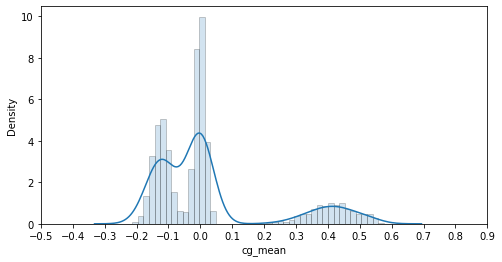

In [203]:
#Popularity change day over day
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(data_stats['cg_mean'], ax=ax, hist_kws=hist_kws)
ax.set(xticks=np.arange(-0.5,1,0.1))
plt.show()

From the plot above, we can see that 
1. the videos that are 20% changing daily will be trending video

2. the videos around  -5% to 5% are the stable video

3. the video below -5% are the everything else.

In [204]:
hot_video = data_stats[data_stats['cg_mean'] > 0.2]
hot_video.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
10,8903.133333,10248.629782,591.0,1882.5,5483.0,11318.5,34789.0,0.353819,0.220112,0.006865,0.238332,0.324975,0.416434,0.780195
13,91228.200000,91574.506421,4746.0,16688.0,45930.0,153985.5,264570.0,0.350798,0.223287,-0.000643,0.171082,0.373361,0.514471,0.629066
15,6184.400000,9384.882059,494.0,1190.0,1705.0,6231.5,33208.0,0.381382,0.313682,-0.048170,0.026856,0.471749,0.656678,0.740953
28,105011.600000,132346.803029,6152.0,14399.0,30084.0,152599.5,405278.0,0.367767,0.239208,-0.045739,0.206640,0.300966,0.502638,0.778389
29,78372.866667,70559.053747,9118.0,16789.5,45226.0,131717.0,212419.0,0.271285,0.228626,-0.028478,0.046231,0.293353,0.455947,0.665369


In [205]:
popular_video = data_stats[(data_stats['cg_mean'] > -0.05) & (data_stats['cg_mean'] < 0.05)]
popular_video.head()

,ct_mean,ct_std,ct_min,ct_25%,ct_50%,ct_75%,ct_max,cg_mean,cg_std,cg_min,cg_25%,cg_50%,cg_75%,cg_max
video_id,,,,,,,,,,,,,,
2,1.737141e+06,114254.355156,1550493.0,1673415.5,1718352.0,1782226.5,2011096.0,-0.014184,0.061794,-0.084904,-0.061459,-0.043876,0.030687,0.095038
3,2.292781e+06,218636.897779,2016210.0,2132336.5,2247587.0,2436222.5,2653063.0,0.008923,0.054069,-0.075863,-0.028293,-0.001068,0.056393,0.097053
4,2.740392e+06,169611.440727,2474228.0,2611162.0,2719547.0,2880268.5,2984146.0,0.011310,0.050495,-0.063991,-0.027125,0.001606,0.050860,0.090804
8,2.049360e+06,157190.210173,1776574.0,1950028.5,2042499.0,2154066.5,2328022.0,0.004013,0.055904,-0.090772,-0.034195,0.009304,0.046501,0.081409
9,3.267333e+02,18.537478,282.0,316.5,328.0,338.5,355.0,0.014110,0.057146,-0.084507,-0.030789,0.018093,0.066753,0.085809


# Q2
What are the main characteristics of the "hot videos"?

In [206]:
data['hot'] = False
data.loc[data['video_id'].isin(hot_video.index), 'hot'] = True
data.head()

,video_id,count,date,length,language,upload_date,quality,interval,dayofweek,hot
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p,28,2,False
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p,36,0,False
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p,22,5,False
3,1472,234,2015-01-04,157,Other,2014-12-10,240p,25,6,False
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p,20,3,True


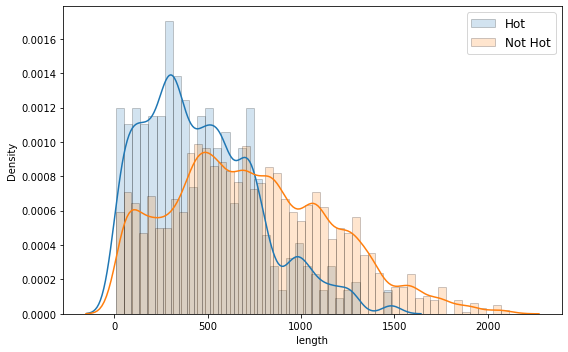

In [207]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data[data['hot']==True]['length'], label='Hot', ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['hot']==False]['length'], label='Not Hot', ax=ax, hist_kws=hist_kws)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

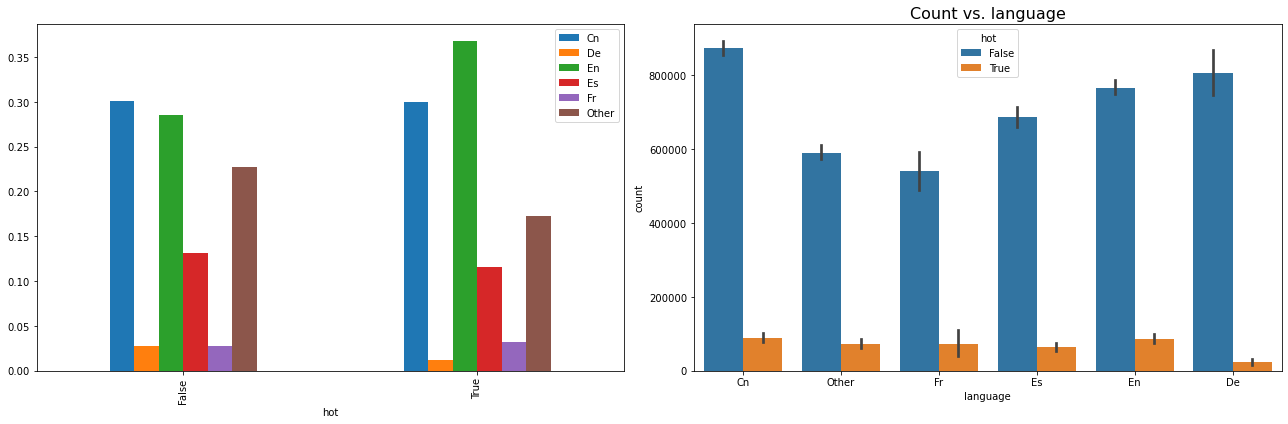

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['language'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='language', y='count', data=data, hue='hot', ax=ax[1])
ax[1].set_title('Count vs. language', fontsize=16)
plt.tight_layout()
plt.show()

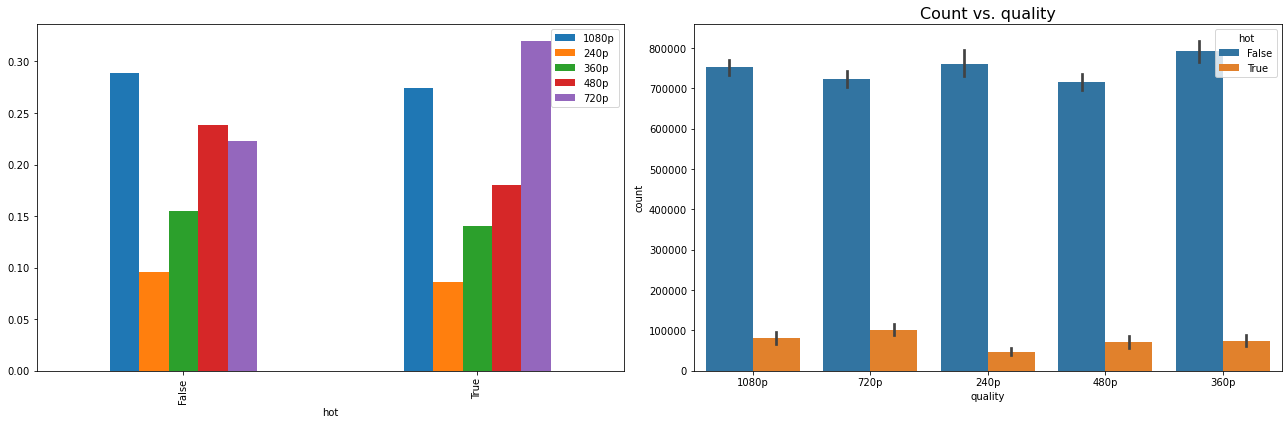

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['quality'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='quality', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. quality', fontsize=16)
plt.tight_layout()
plt.show()

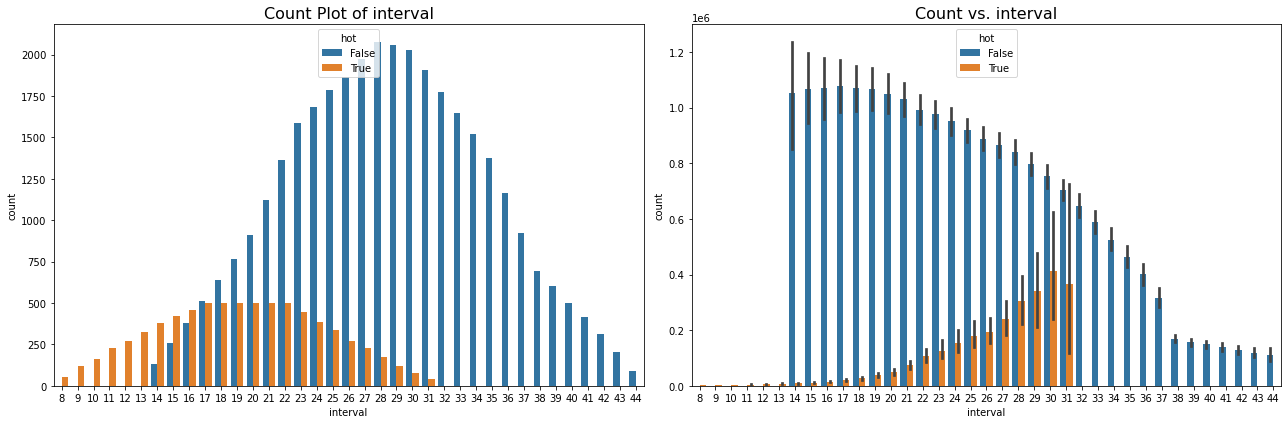

In [210]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='interval', hue='hot', data=data, ax=ax[0])
ax[0].set_title('Count Plot of interval', fontsize=16)

sns.barplot(x='interval', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. interval', fontsize=16)
plt.tight_layout()
plt.show()

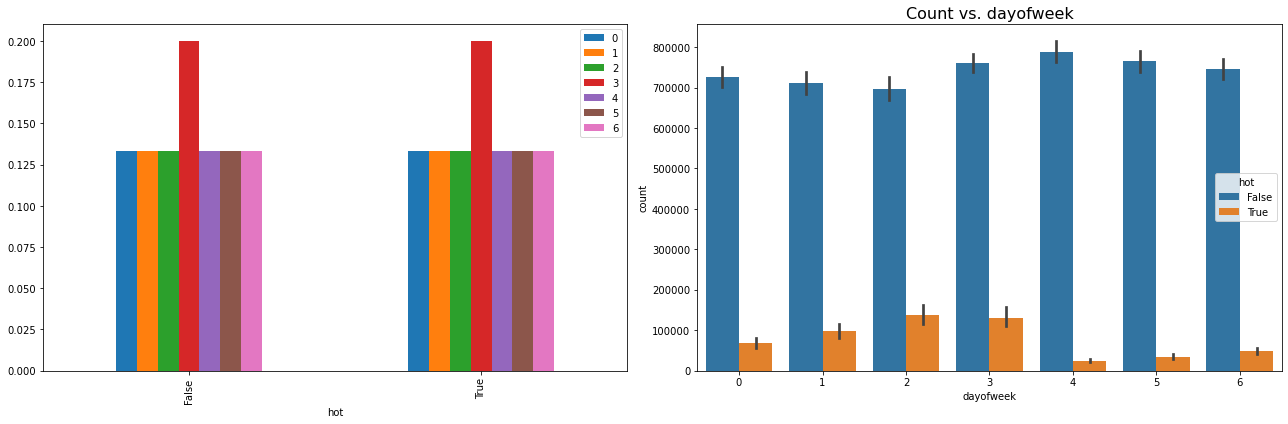

In [211]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
tmp = data.groupby('hot')['dayofweek'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp.plot(kind='bar', ax=ax[0])

sns.barplot(x='dayofweek', y='count', hue='hot', data=data, ax=ax[1])
ax[1].set_title('Count vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

# Q3
After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

We could use these characteristics to build model to predict whether future videos will be hot or not. The video that is predicted to be hot should be featured on the home page to increase the click through rate of the home page.

1. Obviously the video uploaded during the first half of the week are more likely to become hot video.
       - Is it because more people have time to browse videos during these time? Especially during sunday and monday.
       - Does it come with 'share' button to better propogate well? If we do have that button, does it include the popular social platform?
       
2. English video are more likely to be hot than other languages, reason for that should be investigated.

3. Hot video are more likely to be relatively short in length.


Reference: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/18.OnlineVideo/online_videos.ipynb

# Decision Tree Model
decision tree might give us a better explainational power and more insights with feature importance along with our visualization above

In [212]:
X = data[['length', 'language','quality','dayofweek']]
y = data['hot'].apply(lambda x: 1 if x == True else 0)

In [213]:
X = pd.get_dummies(X,columns=['language','dayofweek','quality'],prefix='',prefix_sep='')

In [214]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=20)

In [215]:
feat_importances = pd.Series( dt.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False,inplace=True)
feat_importances

length    0.853731
720p      0.109330
En        0.026096
Other     0.010842
De        0.000000
5         0.000000
480p      0.000000
360p      0.000000
240p      0.000000
1080p     0.000000
6         0.000000
3         0.000000
4         0.000000
Cn        0.000000
1         0.000000
0         0.000000
Fr        0.000000
Es        0.000000
2         0.000000
dtype: float64

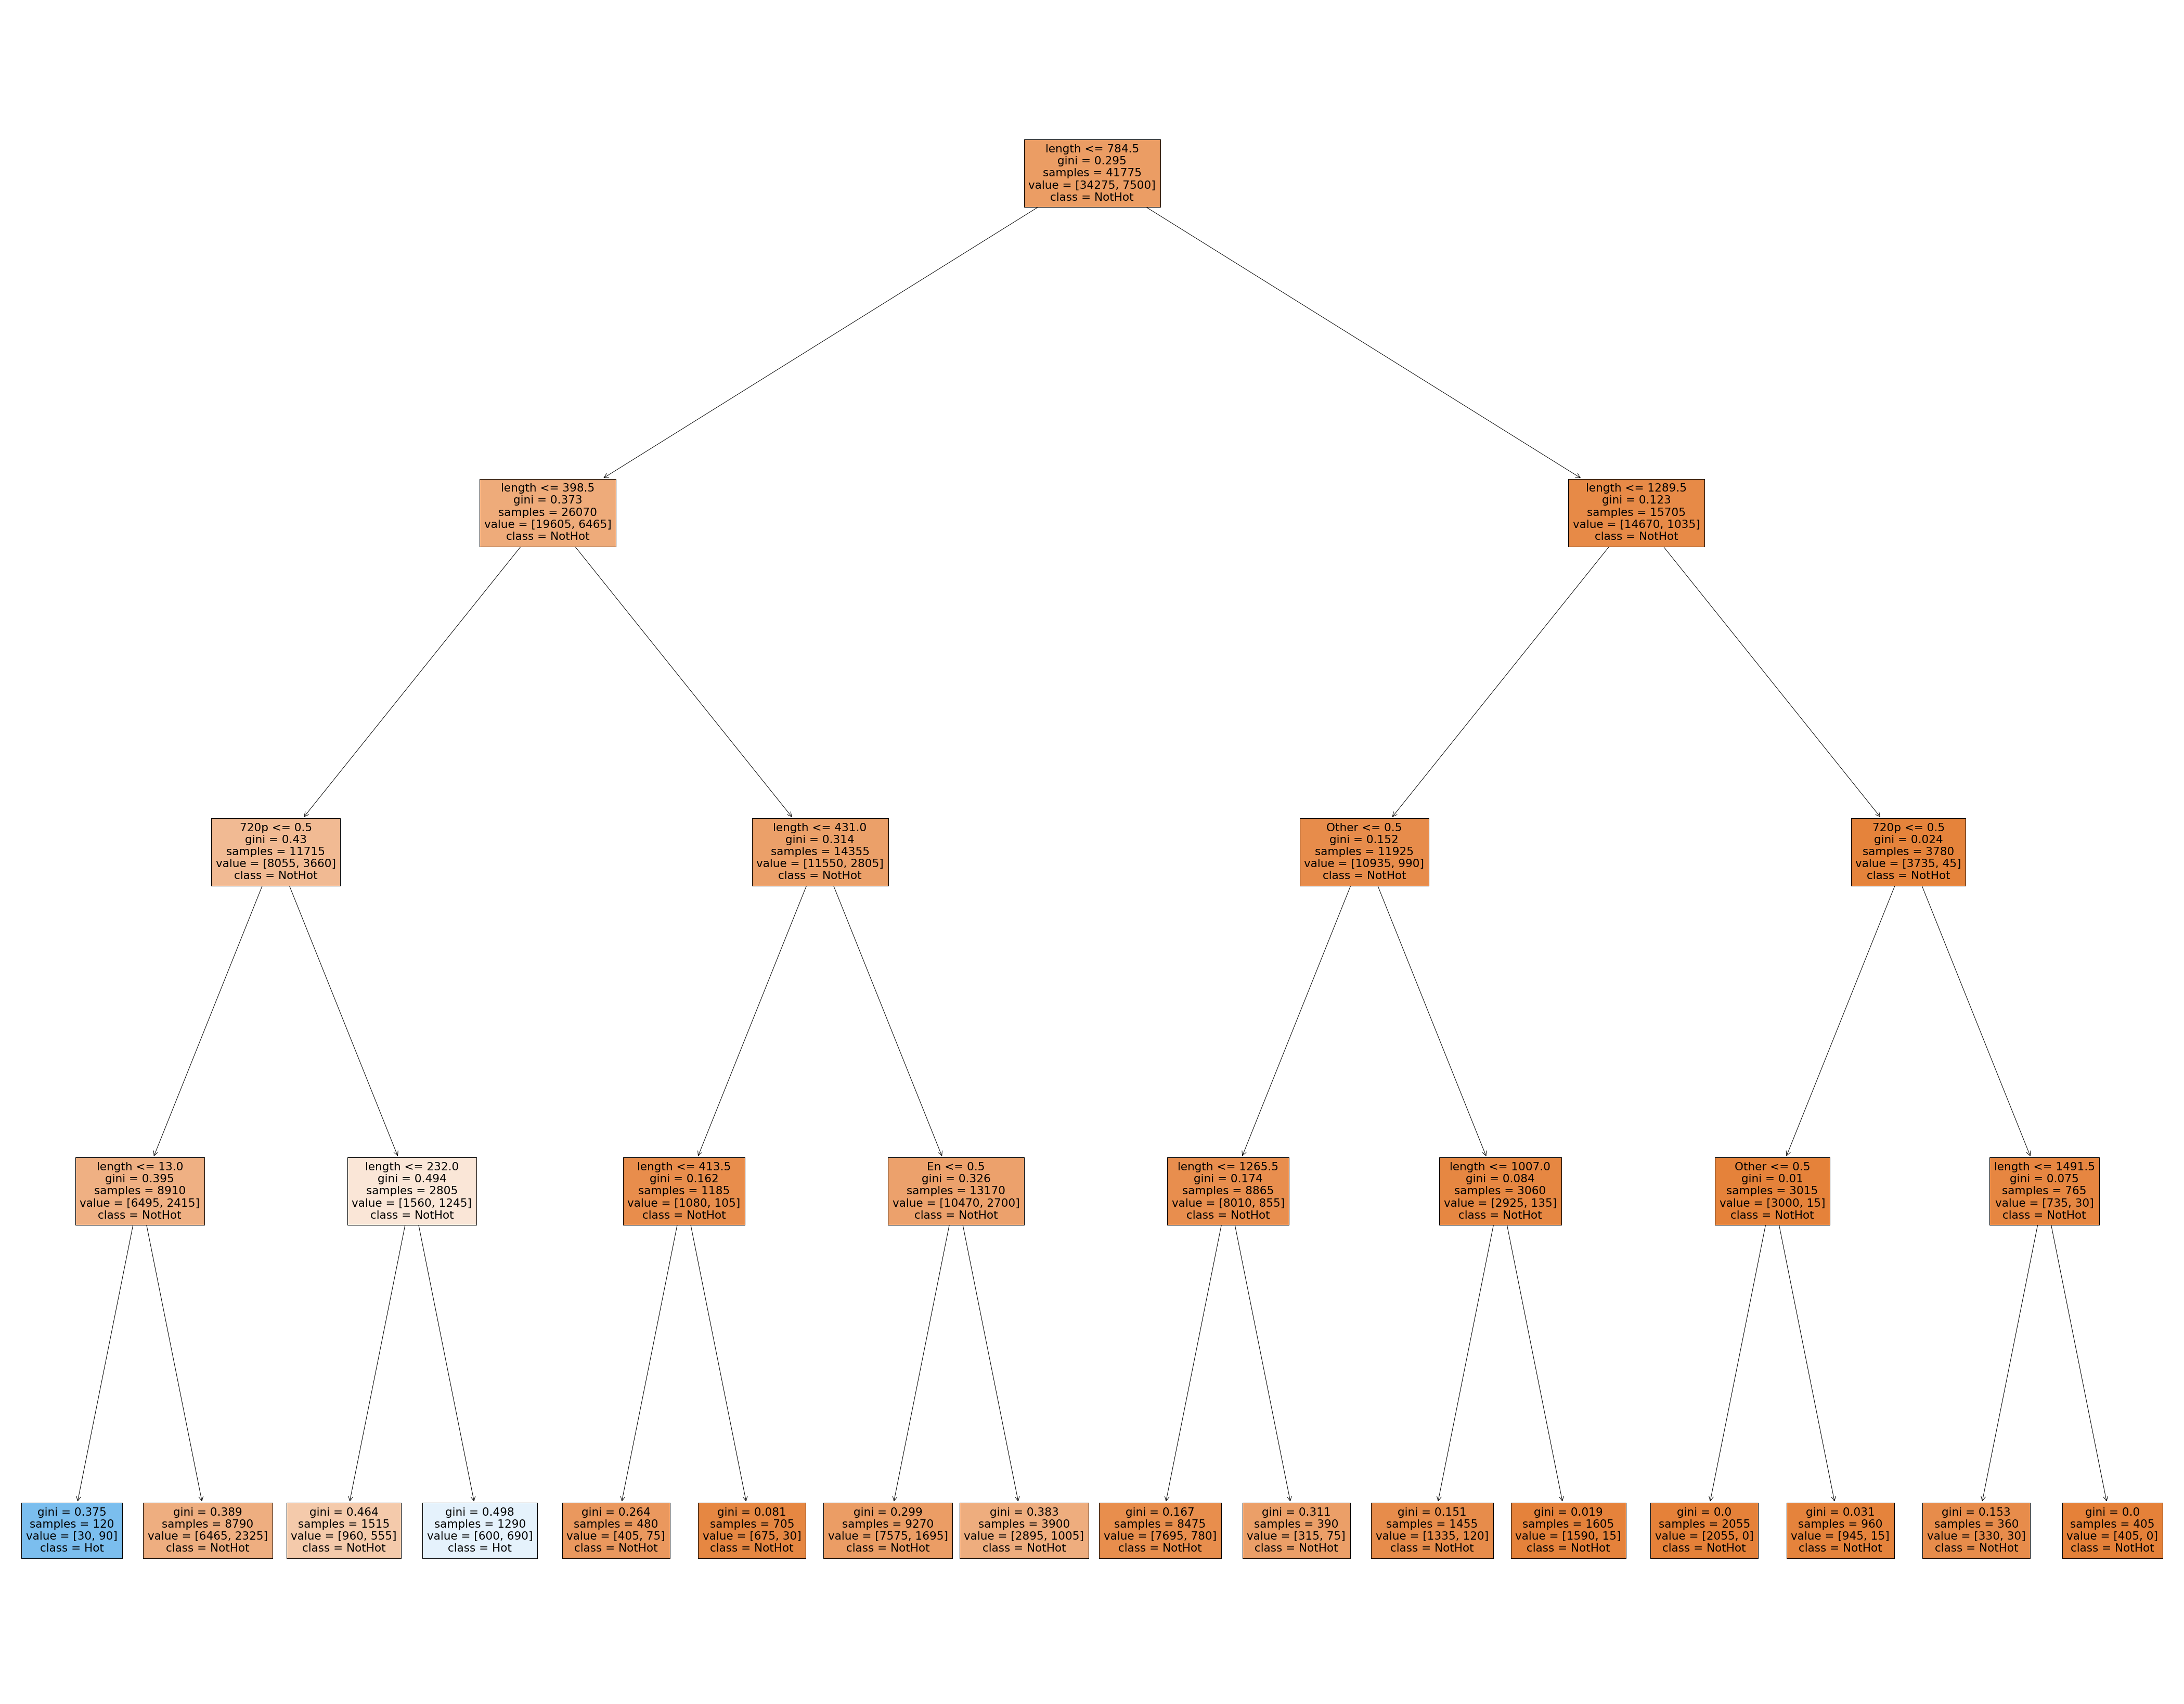

In [216]:
fig = plt.figure(figsize=(75,60))
_ = tree.plot_tree(dt, 
                   feature_names=X.columns,  
                   class_names=['NotHot','Hot'],
                   filled=True)

Based on the decision tree above,

Hot video must be
1. Length <= 398.5
2. preferably 720p in resolution